# Prevendo a nota final dos alunos da Escola Todos Unidos

In [19]:
pip install yellowbrick

  Using cached yellowbrick-1.3.post1-py3-none-any.whl (271 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
#Importações de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Importação de funções das bibliotecas
from matplotlib.font_manager import FontProperties
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.model_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
df_notas = pd.read_csv('student-mat.csv')
df_notas.shape

(395, 33)

In [3]:
#Verificação de dados faltantes
def missing_values_table(df):
        mis_val = df.isnull().sum() # conta a quantidade de missing
        mis_val_percent = 100 * df.isnull().sum() / len(df) # calcula a porcentagem
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) # cria uma tabela
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valores faltantes', 1 : '% do total'}) # renomeia as colunas
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% do total', ascending=False).round(1) # ordena os valores
        print ("Você selecionou um dataframe que tem " + str(df.shape[1]) + " colunas.\n"      
            "E há " + str(mis_val_table_ren_columns.shape[0]) +
              " colunas com valores faltantes")
        return mis_val_table_ren_columns

In [4]:
missing_df = missing_values_table(df_notas)
missing_df.tail()

Você selecionou um dataframe que tem 33 colunas.
E há 0 colunas com valores faltantes


,Valores faltantes,% do total


## Preparação da planilha

### TRATANDO DADOS CATEGÓRICOS: Transformar variáveis categóricas em numéricas
Para análise comparativa das variáveis, precisamos que todas fiquem numéricas

In [5]:
#categorias com strings
categoricas = ['school',\
               'sex',\
              'address',\
              'famsize',\
               'Pstatus',\
               'Mjob',\
               'Fjob',\
               'reason',\
               'guardian',\
               'schoolsup',\
               'famsup',\
               'paid',\
               'activities',\
               'nursery',\
               'higher',\
               'internet',\
               'romantic',
                ]

In [6]:
# Escolher o melhor método (um ficará comentado)
le = LabelEncoder()
# apply le on categorical feature columns
df_notas[categoricas] = df_notas[categoricas].apply(lambda col: le.fit_transform(col))
df_notas[categoricas].head( )

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,0,0,1,0,0,0,4,0,1,1,0,0,0,1,1,0,0
1,0,0,1,0,1,0,2,0,0,0,1,0,0,0,1,1,0
2,0,0,1,1,1,0,2,2,1,1,0,1,0,1,1,1,0
3,0,0,1,0,1,1,3,1,1,0,1,1,1,1,1,1,1
4,0,0,1,0,1,2,2,1,0,0,1,1,0,1,1,0,0


In [ ]:
#oe = OrdinalEncoder()
#categorical = df_notas[categoricas]
#oe.fit(categorical)
#numerical = oe.transform(categorical)

#for n, feat in enumerate(categoricas):
#    df_notas[feat] = numerical[:, n]
#df_notas.head( )

### Normalização dos dados
A normalização dos dados coloca-os na mesma ordem de grandeza

In [7]:
#Este processo PADRONIZA as variáveis
escala = StandardScaler().fit(df_notas)
df_notasN = escala.transform(df_notas)
df_notas = pd.DataFrame(StandardScaler().fit_transform(df_notasN), columns=df_notas.columns, index=df_notas.index)

In [ ]:
#Este processo NORMALIZA as variáveis - ESCOLHER APENAS UM PROCESSO
#escala = Normalizer().fit(df_notas)
#df_notasN = escala.transform(df_notas)
#df_notas = pd.DataFrame(Normalizer().fit_transform(df_notasN), columns=df_notas.columns, index=df_notas.index)

### Construindo gráficos de demonstração de importância das variáveis

In [8]:
X = df_notas.drop('G3', axis=1)
y = df_notas['G3']
print(X.shape)
print(y.shape)

(395, 32)
(395,)


## Dados preparados para escolha do tipo de algoritmo
O algoritmo escolhido após vários testes foi o DecisionTreeRegressor

### Gráficos Yellowbrick

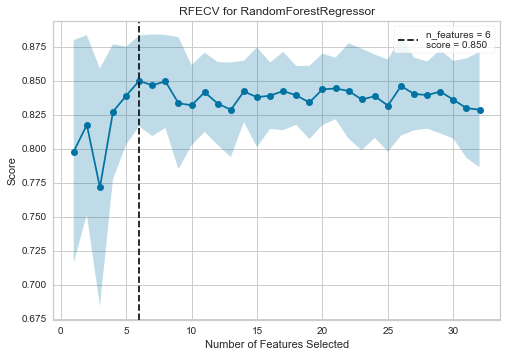

<AxesSubplot:title={'center':'RFECV for RandomForestRegressor'}, xlabel='Number of Features Selected', ylabel='Score'>

In [9]:
#Gera um gráfico com a melhor quantidade de variáveis a ser considerada e quais são elas
#cv = StratifiedKFold(5) - LINHA COMENTADA PQ O CROSSVALIDATION ESTAVA DANDO ERRO DE VARIÁVEL TIPO CONTINUOUS
visualizer = RFECV(RandomForestRegressor(), cv=5, scoring='r2')
visualizer.fit(X, y)
visualizer.show()

In [10]:
X.loc[:, X.columns != 'IN_TREINEIRO'].columns[visualizer.support_] #pegar as colunas que ele retornou como importante

Index(['age', 'famrel', 'health', 'absences', 'G1', 'G2'], dtype='object')

### Depois de aplicar o Yellowbrick

In [12]:
#Cria planilha nova APENAS COM as features que o Yellowbrick considerou IMPORTANTES (drop nas demais)
#df_notas3 = df_notas.drop(['school', 'sex', 'address', 'famsize', 'Pstatus', 'guardian', 'schoolsup', 'famsup', 'paid', 
#                           'nursery', 'higher', 'internet', 'romantic', 'Dalc', 'G3'], axis=1)
df_notas3 = df_notas.loc[:, ['age', 'famrel', 'health', 'absences', 'G1', 'G2']]

In [13]:
X = df_notas3
y = df_notas['G3']
regressor2= DecisionTreeRegressor(random_state = 0)

#Variável teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#fit tregressor with X and y data
regressor2.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [14]:
y_pred = regressor2.predict(X_test)

#### Métricas do Modelo só com as colunas indicadas no Yellowbrick como importantes 

In [17]:
#avaliação da qualidade do modelo
score = regressor2.score(X_test, y_test)
print('Score:', score)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred)) #próx de 0, melhor
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #medida de dispersão

Score: 0.826825961810285
Mean Absolute Error: 0.22956794030483044
Mean Squared Error: 0.18182249496360003
Root Mean Squared Error: 0.4264064902925377


### Aplicando o regressor

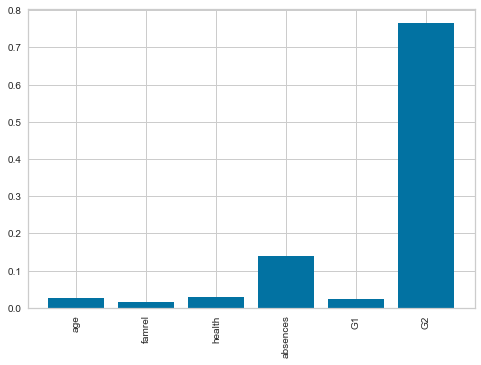

In [18]:
features_n = X.columns
regr_2 = DecisionTreeRegressor()
regr_2.fit(X, y)
DTR_teste = regr_2.feature_importances_
# plot feature importance
plt.bar([x for x in range(len(DTR_teste))], DTR_teste)
plt.xticks([x for x in range(len(DTR_teste))], features_n, rotation='vertical')
plt.show()

## Planilha completa - DecisionTreeRegressor

In [19]:
X = df_notas.drop('G3', axis=1)
y = df_notas['G3']
regressor2= DecisionTreeRegressor(random_state = 0)

#Variável teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#fit tregressor with X and y data
regressor2.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [20]:
y_pred = regressor2.predict(X_test)

#### Métricas do modelo Planilha completa - DecisionTreeRegressor

In [21]:
score = regressor2.score(X_test, y_test)
print('Score:', score)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred)) #próx de 0, melhor
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #medida de dispersão

Score: 0.8012130245945877
Mean Absolute Error: 0.2534430060965329
Mean Squared Error: 0.2087145637551259
Root Mean Squared Error: 0.45685289071551893


### Aplicando o regressor

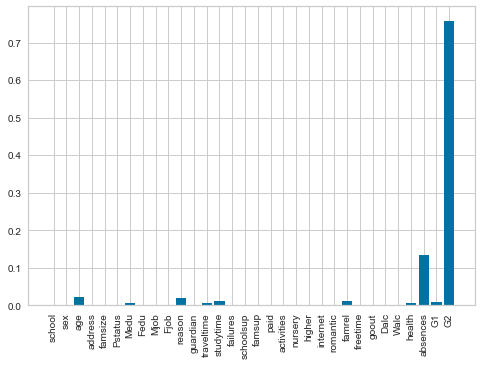

In [22]:
features_n = X.columns
regr_2 = DecisionTreeRegressor()
regr_2.fit(X, y)
DTR_teste = regr_2.feature_importances_
# plot feature importance
plt.bar([x for x in range(len(DTR_teste))], DTR_teste)
plt.xticks([x for x in range(len(DTR_teste))], features_n, rotation='vertical')
plt.show()